# Compare two hover flight

## Import statements and notebook settings

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

import seaborn as sns

from tools.helper_functions import moving_average, normalize, rolling_normal, perform_polynomial_regression
from tools.data_loader import load_flight_data, select_sequence, clean_data, apply_motor_calibration
from tools.data_loader import correct_motor_current

import tools.data_loader as dl

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from scipy import stats

import glob
import os

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# declare ALL list objects necessary

vInduced = 14.345219306215128 # induced velocity for firefly vehicle
markersize= 15 # global markersize setting for scatter plots

# set colors

lowCol = '#FF7518' # pumpkin orange
upCol = '#18A2FF' # complementary color

upMeanCol = 'blue'
lowMeanCol = 'black'

armCol = upCol
armMeanCol = 'red'

## Load flight data

In [4]:
# select test flight

# first testflight
#flight = f'../flight_data/2022-08-01_ag_field/flight_6_first_hover_flight/'
#hoverStart = 35
#hoverEnd = 15

# second testflight
pathFlight1 = f'../flight_data/2022-08-01_ag_field/flight_8_second_hover_flight/'
hoverStart1 = 30
hoverEnd1 = 190

## third testflight
pathFlight2 = f'../flight_data/2022-08-29_ag_field/flight_2_delta0_sweep/'
hoverStart2 = 150
hoverEnd2 = 530

In [5]:
fd1 = load_flight_data(pathFlight1)
fd2 = load_flight_data(pathFlight2)

fd1 = dl.convert_time(fd1)
fd2 = dl.convert_time(fd2)

## Preprocessing

### Rename columns and calculate power values for motors, arms and vehicle

In [6]:
fd1 = clean_data(fd1)
fd2 = clean_data(fd2)

### Apply calibration for ESC current and voltage

In [7]:
fd1 = apply_motor_calibration(fd1)
fd2 = apply_motor_calibration(fd2)

### Correct current signal for motor 3

For unknown reasons the current sensor of motor 3 is not capable of detecting values below 2.66 A. This can lead to a bias in the power signal for motor 3. For this reason, we perform a linear regression for current and RPM signal, as the RPM signal is considered more reliable. All values below 2.66 A are replaced with the predictions for the RPM value  

In [8]:
fd1_old = fd1.copy(deep=True)
fd2_old = fd2.copy(deep=True)

fd1, minI3_1 = correct_motor_current(fd1)
fd2, minI3_2 = correct_motor_current(fd2)

<IPython.core.display.Javascript object>


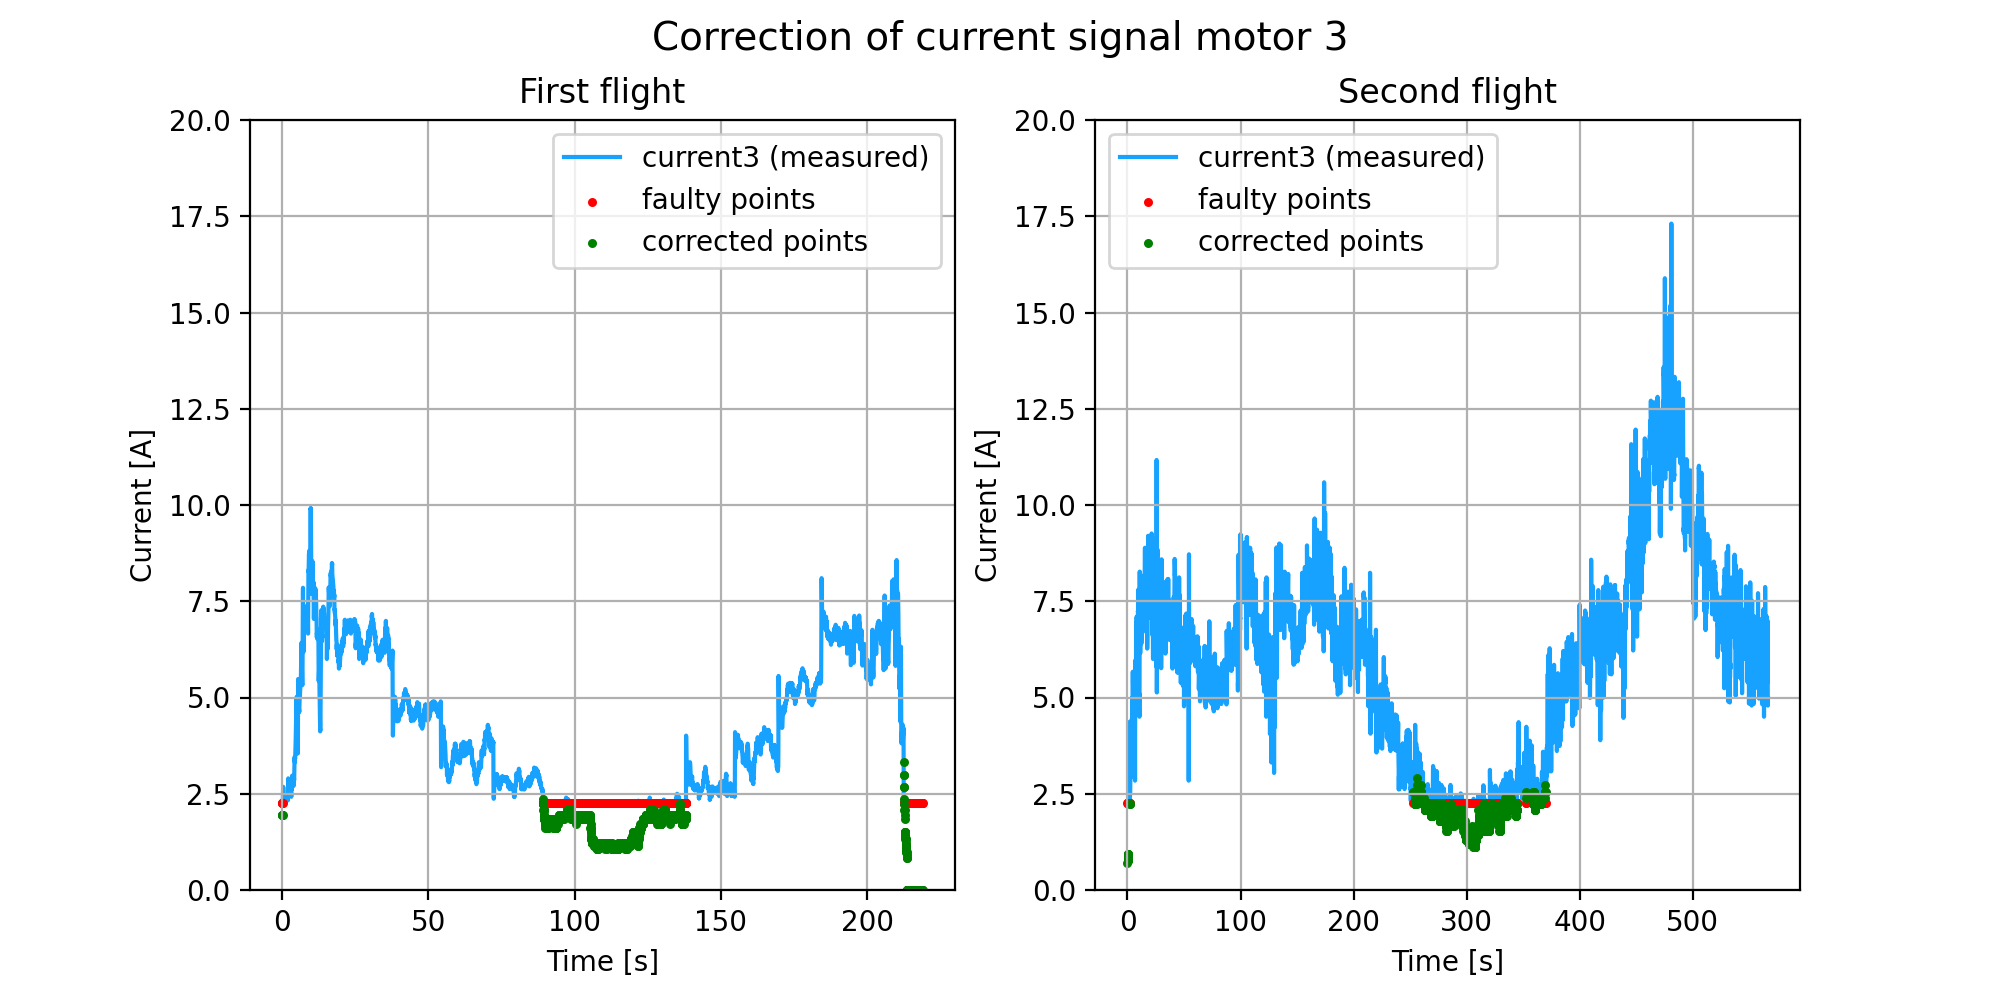

In [9]:
figCurrent, axCurrent = plt.subplots(1,2, figsize=(10,5))
figCurrent.suptitle("Correction of current signal motor 3", fontsize=14)

# plot current over time for motor 3
axCurrent[0].plot(fd1_old['t'], fd1_old['I3'], color=upCol, label='current3 (measured)', zorder=1)
axCurrent[1].plot(fd2_old['t'], fd2_old['I3'], color=upCol, label='current3 (measured)', zorder=1)

# mark points that will replaced with red color
axCurrent[0].scatter(fd1_old['t'][minI3_1], fd1_old['I3'][minI3_1], color='r', s=5, label='faulty points')
axCurrent[1].scatter(fd2_old['t'][minI3_2], fd2_old['I3'][minI3_2], color='r', s=5, label='faulty points')

# mark points that were replaced with red color
axCurrent[0].scatter(fd1['t'][minI3_1], fd1['I3'][minI3_1], color='g', s=5, label='corrected points')
axCurrent[1].scatter(fd2['t'][minI3_2], fd2['I3'][minI3_2], color='g', s=5, label='corrected points')

axCurrent[0].set_title("First flight")
axCurrent[1].set_title("Second flight")

for i in range(2):
    axCurrent[i].set_xlabel('Time [s]')
    axCurrent[i].set_ylabel('Current [A]')
    axCurrent[i].set_ylim(0,20)
    axCurrent[i].grid()
    axCurrent[i].legend()


### Calculate power and controls

In [10]:
fd1 = dl.calculate_power_and_rpm(fd1)
fd2 = dl.calculate_power_and_rpm(fd2)

### Calculate motor commands

In [11]:
fd1 = dl.calculate_motor_cmds(fd1)
fd2 = dl.calculate_motor_cmds(fd2)

### Filter out hover sequence DataFrame

In [12]:
# Reset current correction
hoverIndex1, fdHover1 = select_sequence(fd1, hoverStart1, hoverEnd1)
hoverIndex2, fdHover2 = select_sequence(fd2, hoverStart2, hoverEnd2)

### Remove values after $\Delta_0$-step

In [13]:
fdUnfiltered1 = fdHover1.copy(deep=True)
fdUnfiltered2 = fdHover2.copy(deep=True)

In [14]:
steps1 = fdHover1[np.abs(fdHover1['delta0'].diff()) > 0]
steps2 = fdHover2[np.abs(fdHover2['delta0'].diff()) > 0]

for i in steps1.index:
    toDrop = np.arange(i,i+20)
    fdHover1 = fdHover1.drop(index=toDrop)

for i in steps2.index:
    toDrop = np.arange(i,i+20)
    fdHover2 = fdHover2.drop(index=toDrop)

### Create lists that contain data for both flights

In [15]:
flight = [fd1, fd2]
fdHover = [fdHover1, fdHover2]
start = [hoverStart1, hoverStart2]
end = [hoverEnd1, hoverEnd2]
hoverIndex = [hoverIndex1, hoverIndex2]

<IPython.core.display.Javascript object>


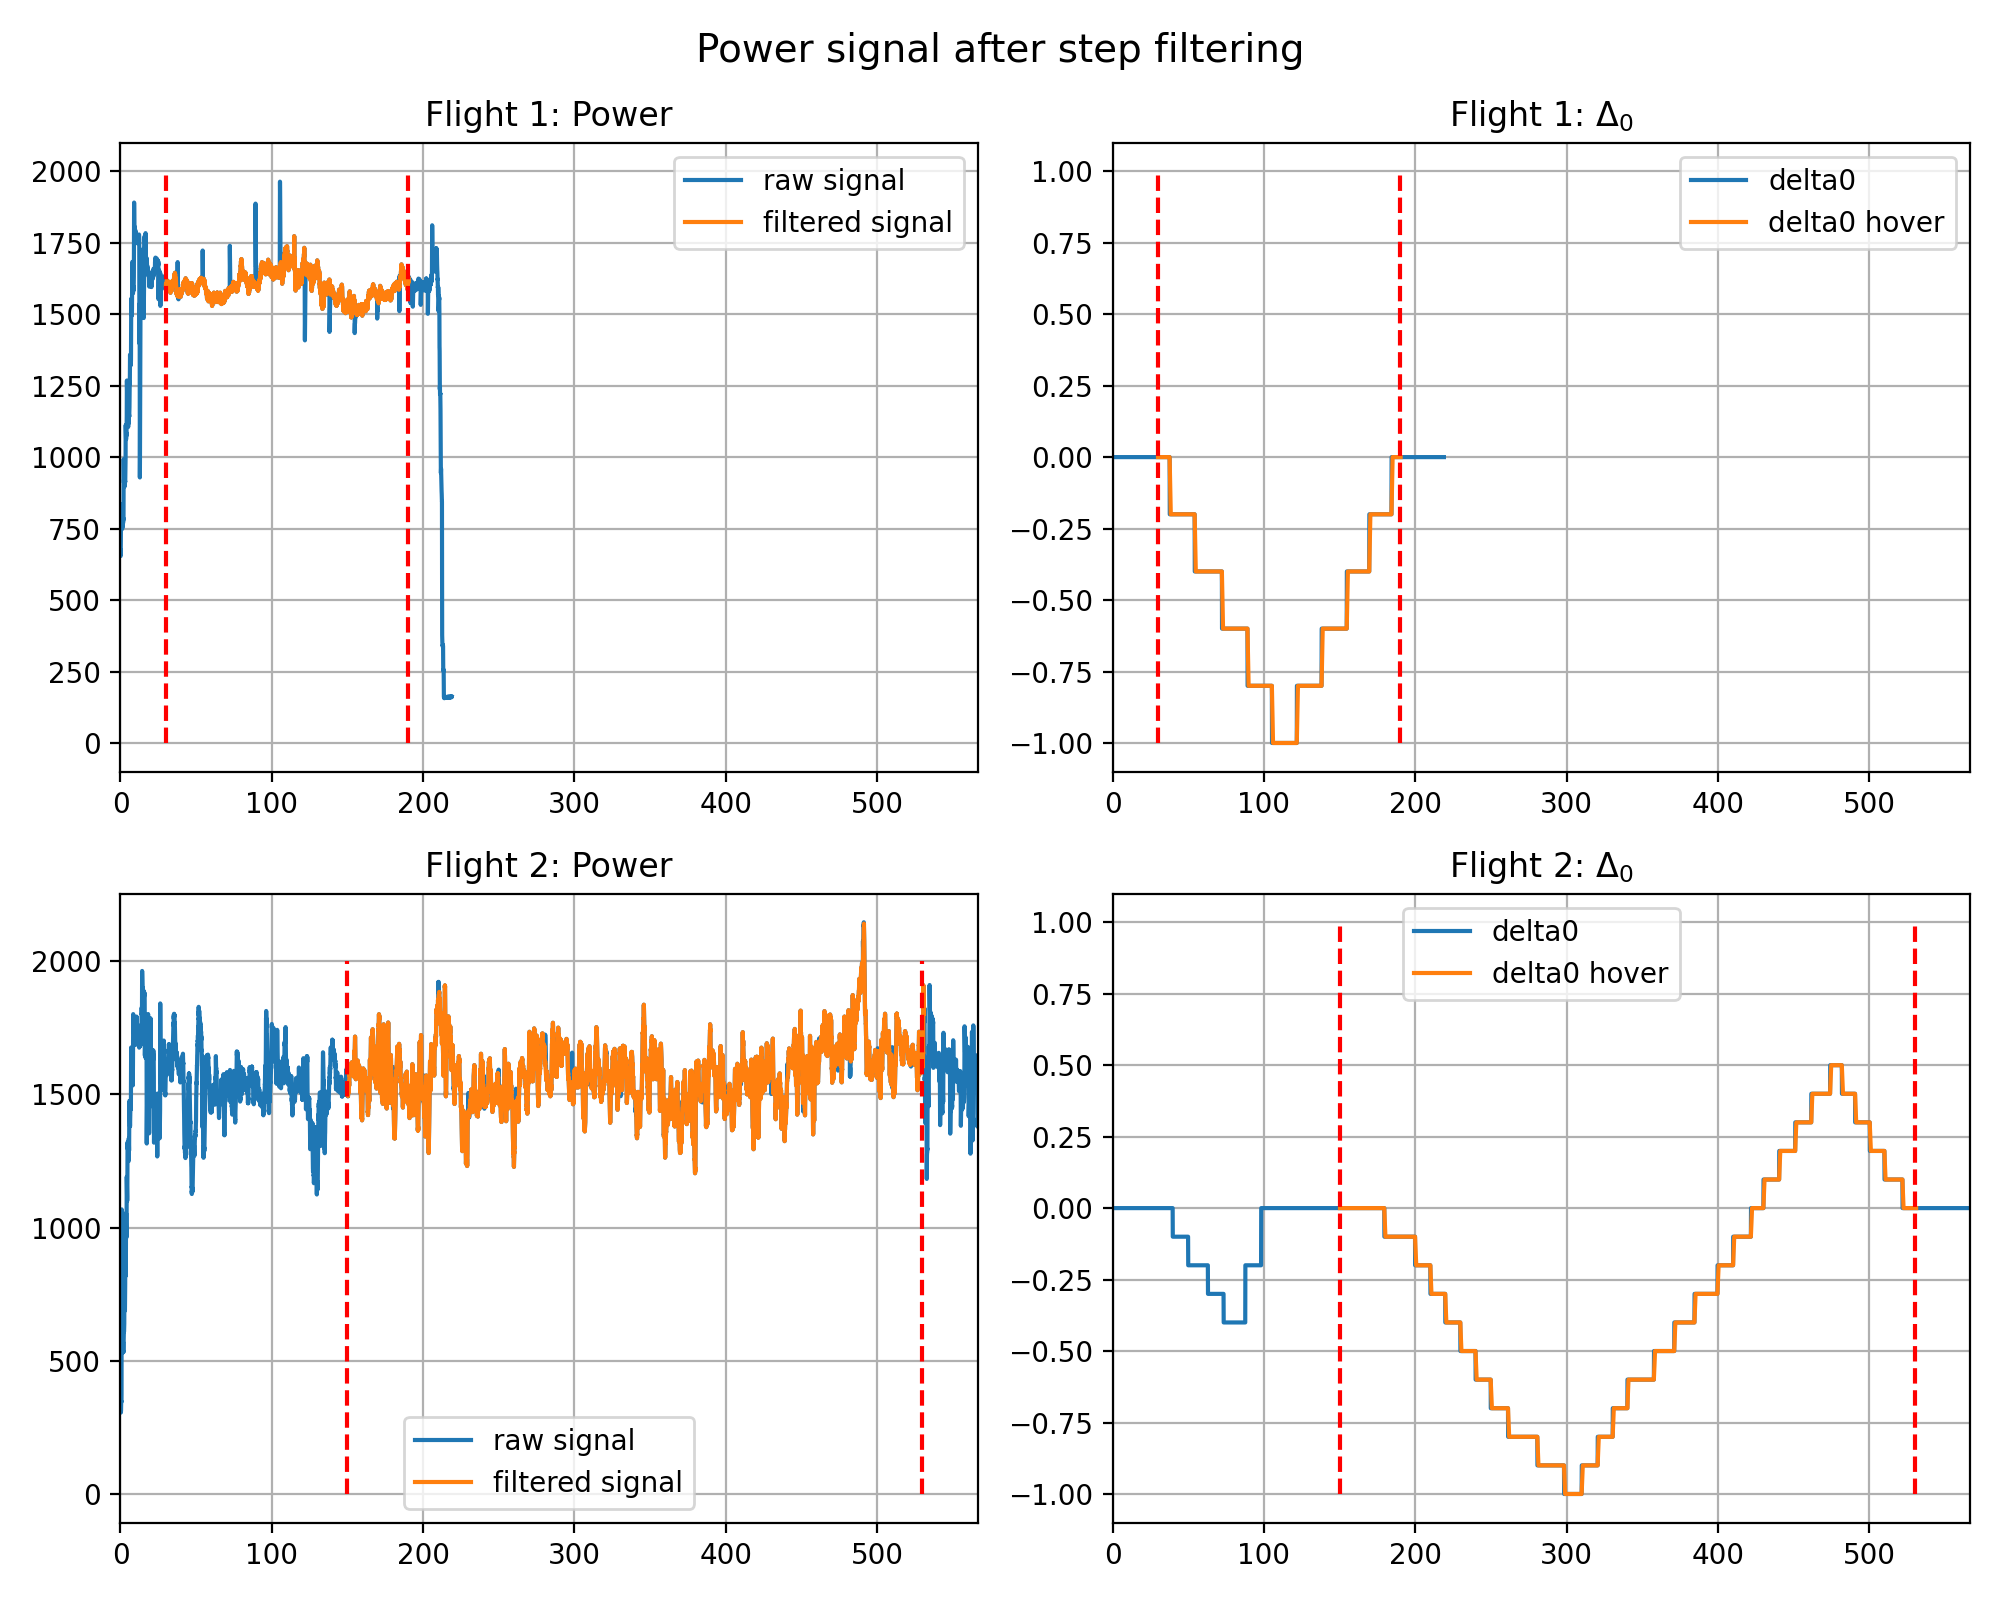

In [16]:
fig0, ax0 = plt.subplots(2,2,figsize=(10,8))
fig0.suptitle('Power signal after step filtering', fontsize=14)

for i in range(2):
    
    ax0[i][0].plot(flight[i]['t'], flight[i]['pVehicle'], label='raw signal')
    ax0[i][0].plot(fdHover[i]['t'], fdHover[i]['pVehicle'], label='filtered signal')

    ax0[i][1].plot(flight[i]['t'], flight[i]['delta0'], label='delta0')
    ax0[i][1].plot(fdHover[i]['t'], fdHover[i]['delta0'], label='delta0 hover')

    # add red boundary lines to highlight separation between take-off/landing and hovering
    ax0[i][1].plot([start[i], start[i]],[-1, 1], 'r--')
    ax0[i][1].plot([end[i], end[i]],[-1, 1], 'r--')
    
    # add red boundary lines to highlight separation between take-off/landing and hovering
    ax0[i][0].plot([start[i], start[i]],[0, 2000], 'r--')
    ax0[i][0].plot([end[i], end[i]],[0, 2000], 'r--')
    
    ax0[0][0].set_title('Flight 1: Power')
    ax0[0][1].set_title('Flight 1: $\Delta_0$')
    ax0[1][0].set_title('Flight 2: Power')
    ax0[1][1].set_title('Flight 2: $\Delta_0$')
    
    for j in range(2):
        
        ax0[i][j].set_xlim(0, max(flight[1]['t']))
        ax0[i][j].set_xlim(0, max(flight[1]['t']))
        ax0[i][j].grid()
        ax0[i][j].legend()

fig0.tight_layout()

### Calculate mean and median values for each $\Delta_0$

In [17]:
delta0Mean = [pd.pivot_table(fdHover1, index='delta0', aggfunc=np.mean)]
delta0Mean.append(pd.pivot_table(fdHover2, index='delta0', aggfunc=np.mean))

delta0Median = [pd.pivot_table(fdHover1, index='delta0', aggfunc=np.median)]
delta0Median.append(pd.pivot_table(fdHover2, index='delta0', aggfunc=np.median))

## Start of analysis

### Calculate v_norm

In [18]:
# vnorm in percentage of v_i

vNorm1 = np.sqrt(fd1['u']**2 + fd1['v']**2 + fd1['w']**2)
vNorm2 = np.sqrt(fd2['u']**2 + fd2['v']**2 + fd2['w']**2)

vNormPercentage1 = (vNorm1/vInduced)*100
vNormPercentage2 = (vNorm2/vInduced)*100

vNorm = [vNorm1, vNorm2]
vNormPercentage = [vNormPercentage1, vNormPercentage2]

fdUnfiltered = [fdUnfiltered1, fdUnfiltered2]

<IPython.core.display.Javascript object>


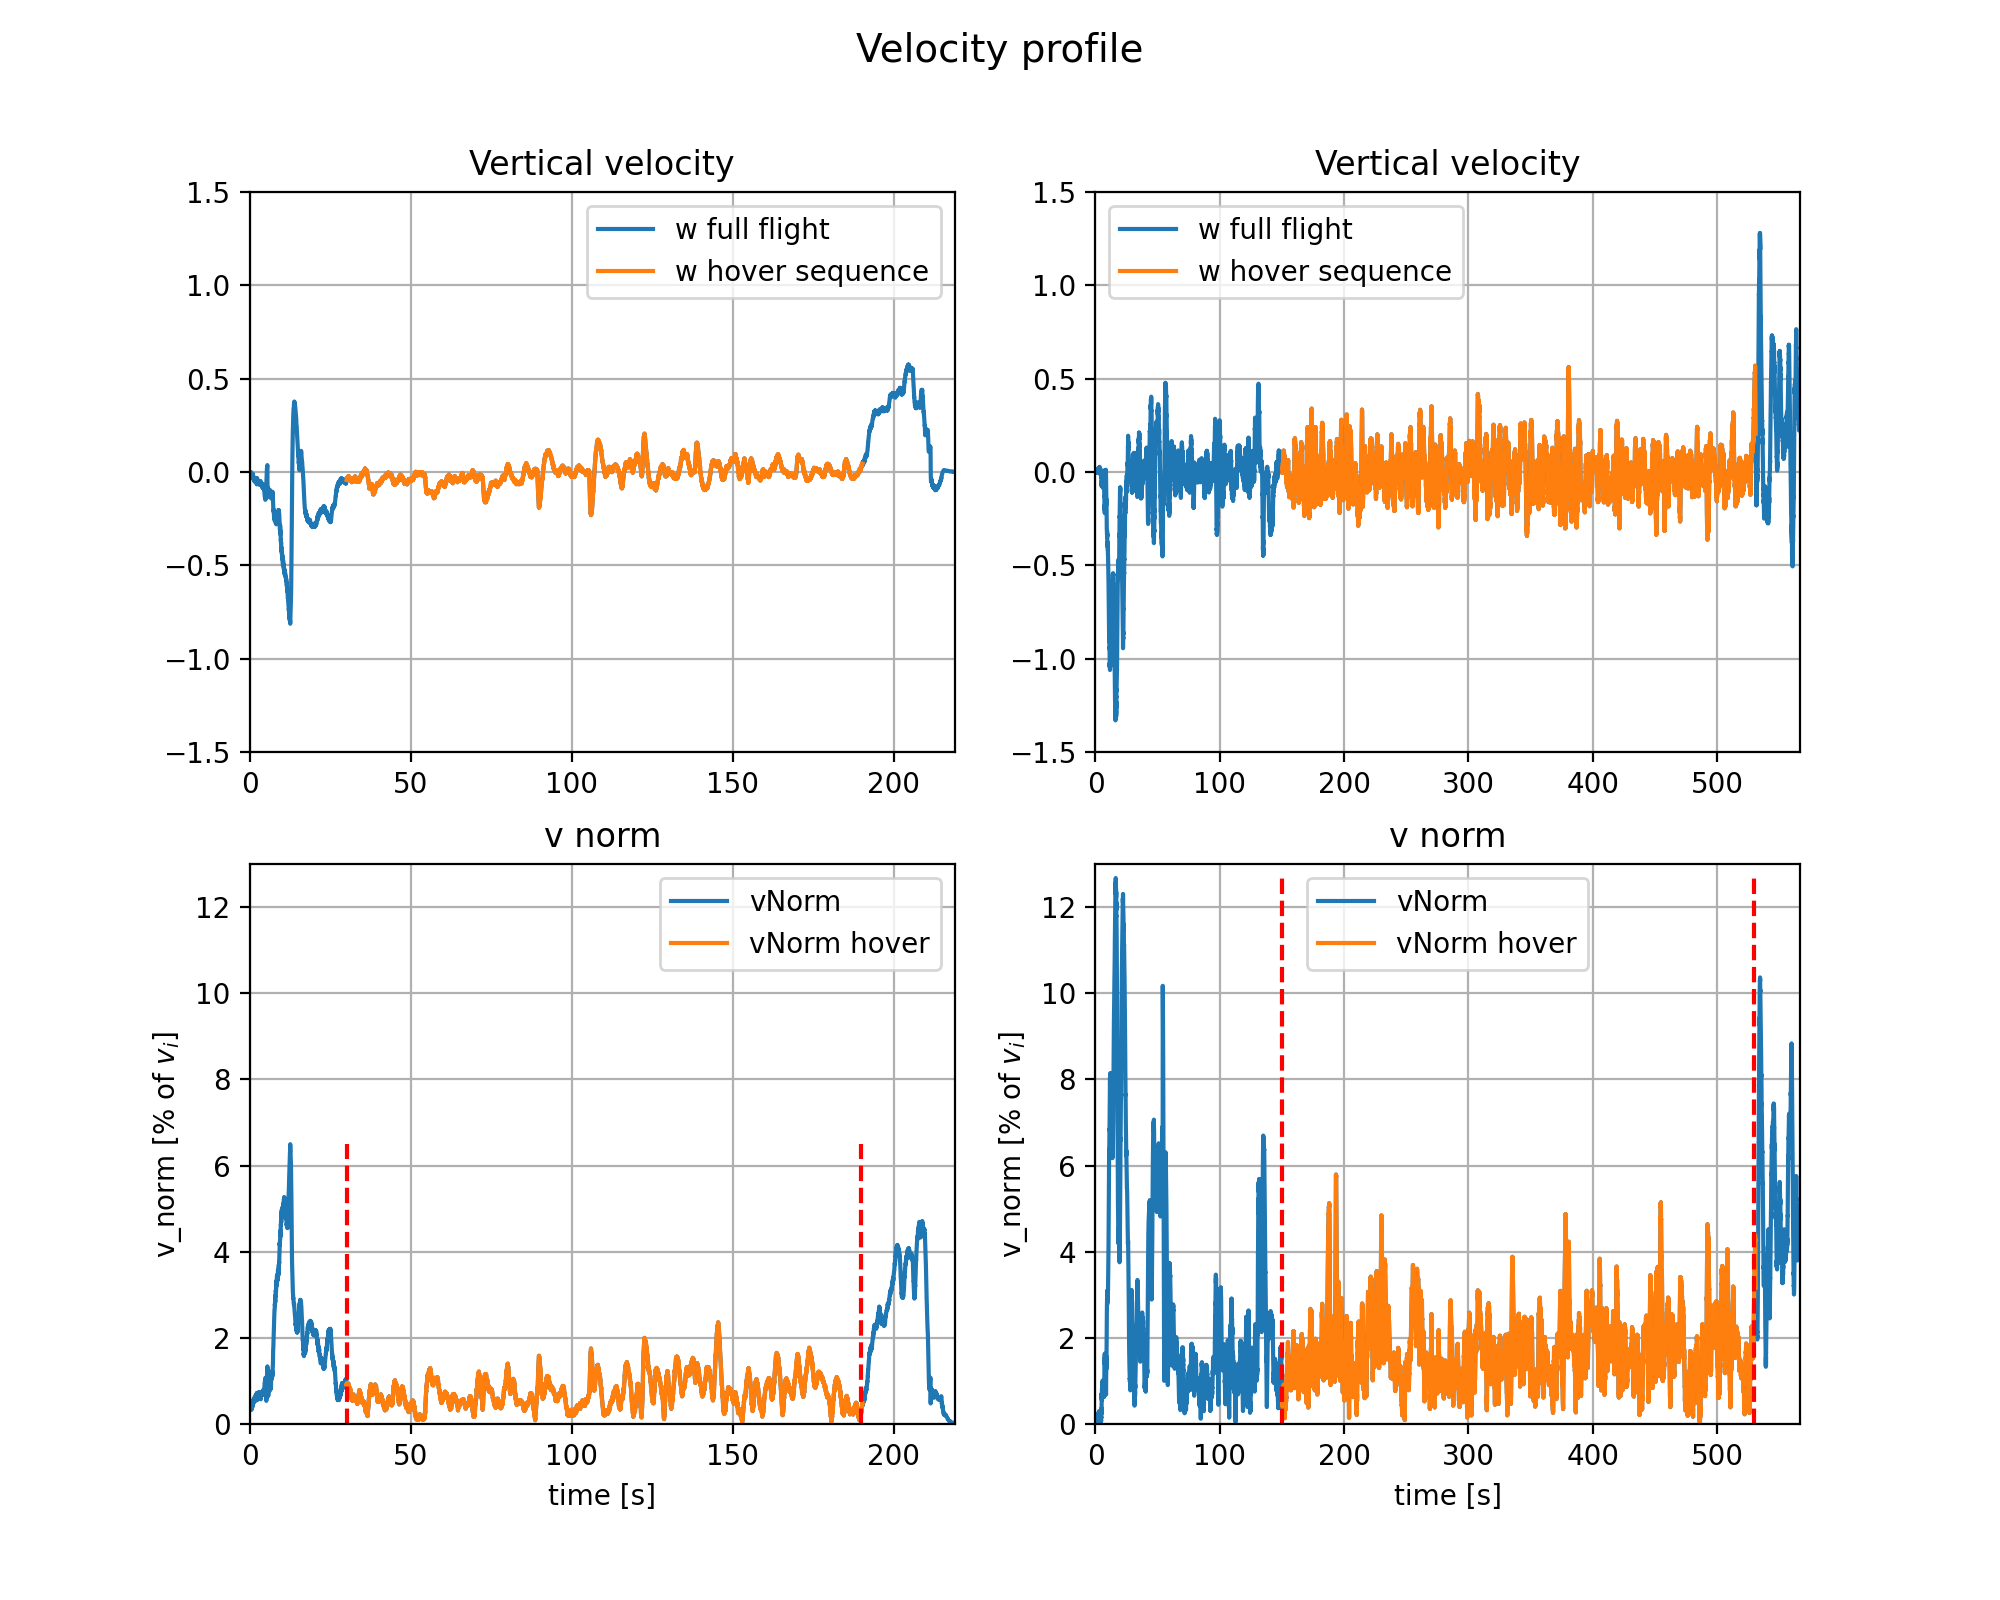

In [19]:
# plot histogram of vnorm with corresponding limit

fi1, a1 = plt.subplots(2, 2, figsize=(10,8))
fi1.suptitle('Velocity profile', fontsize=14)

for i in range(2):
    
    # plot moving average of vertical velocity w and highlight the hovering sequence
    a1[0][i].plot(flight[i]['t'], flight[i]['w'], label='w full flight')
    a1[0][i].plot(flight[i]['t'].iloc[hoverIndex[i]], flight[i]['w'].iloc[hoverIndex[i]], label='w hover sequence')

    # plot v_norm and hightlight hover sequence
    a1[1][i].plot(flight[i]['t'], vNormPercentage[i], label='vNorm')
    a1[1][i].plot(flight[i]['t'].iloc[hoverIndex[i]], vNormPercentage[i].iloc[hoverIndex[i]], label='vNorm hover')

    # add red boundary lines to highlight separation between take-off/landing and hovering
    a1[1][i].plot([start[i], start[i]],[0, np.max(vNormPercentage[i])], 'r--')
    a1[1][i].plot([end[i], end[i]],[0, np.max(vNormPercentage[i])], 'r--')

    # add grid, legend, labels, etc.
    a1[0][i].grid()
    a1[0][i].legend()
    a1[0][i].set_title('Vertical velocity')
    a1[0][i].set_xlim(min(flight[i]['t']), max(flight[i]['t']))
    
    a1[0][i].set_ylim(-1.5, 1.5)
    a1[1][i].set_ylim(0, 13)

    a1[1][i].set_title('v norm')
    a1[1][i].set_xlabel('time [s]')
    a1[1][i].set_ylabel('v_norm [% of $v_i$]')
    a1[1][i].grid()
    a1[1][i].legend()
    a1[1][i].set_xlim(min(flight[i]['t']),max(flight[i]['t']))

### Calculate average vNorm

In [20]:
vNormAvg1 = np.around(vNorm1.mean(), 3)
vNormAvg2 = np.around(vNorm2.mean(), 3)

vNormPrctAvg1 = np.around(vNormPercentage1.mean(), 3)
vNormPrctAvg2 = np.around(vNormPercentage2.mean(), 3)

print(f"The average vNorm for flight 1 is {vNormAvg1} m/s ({vNormPrctAvg1} % of induced velocity)")
print(f"The average vNorm for flight 2 is {vNormAvg2} m/s ({vNormPrctAvg2} % of induced velocity)")

The average vNorm for flight 1 is 0.161 m/s (1.125 % of induced velocity)
The average vNorm for flight 2 is 0.311 m/s (2.168 % of induced velocity)


## Compare power per arm

In [21]:
# estimate kernel density

kernelDensity = []

for j in range(2):
    density = []
    for i in range(1,5):
        values = np.vstack([fdHover[j][f"dRpmArm{i}"], fdHover[j][f"pArm{i}"]])
        density.append(stats.gaussian_kde(values)(values))
    kernelDensity.append(density)

In [22]:
# create regression curves

dRpmRange = []
dRpmRegCurve = []
dRpmMin = []

for i in range(2):
    
    flightRange = []
    flightCurve = []
    flightMin = []
    
    for j in range(4):
        regRange, regCurve = perform_polynomial_regression(fdHover[i], f'dRpmArm{j+1}', f'pArm{j+1}')
        flightRange.append(regRange)
        flightCurve.append(regCurve)
        flightMin.append(regRange[np.argmin(regCurve)])
    
    dRpmRange.append(flightRange)
    dRpmRegCurve.append(flightCurve)
    dRpmMin.append(flightMin)

<IPython.core.display.Javascript object>


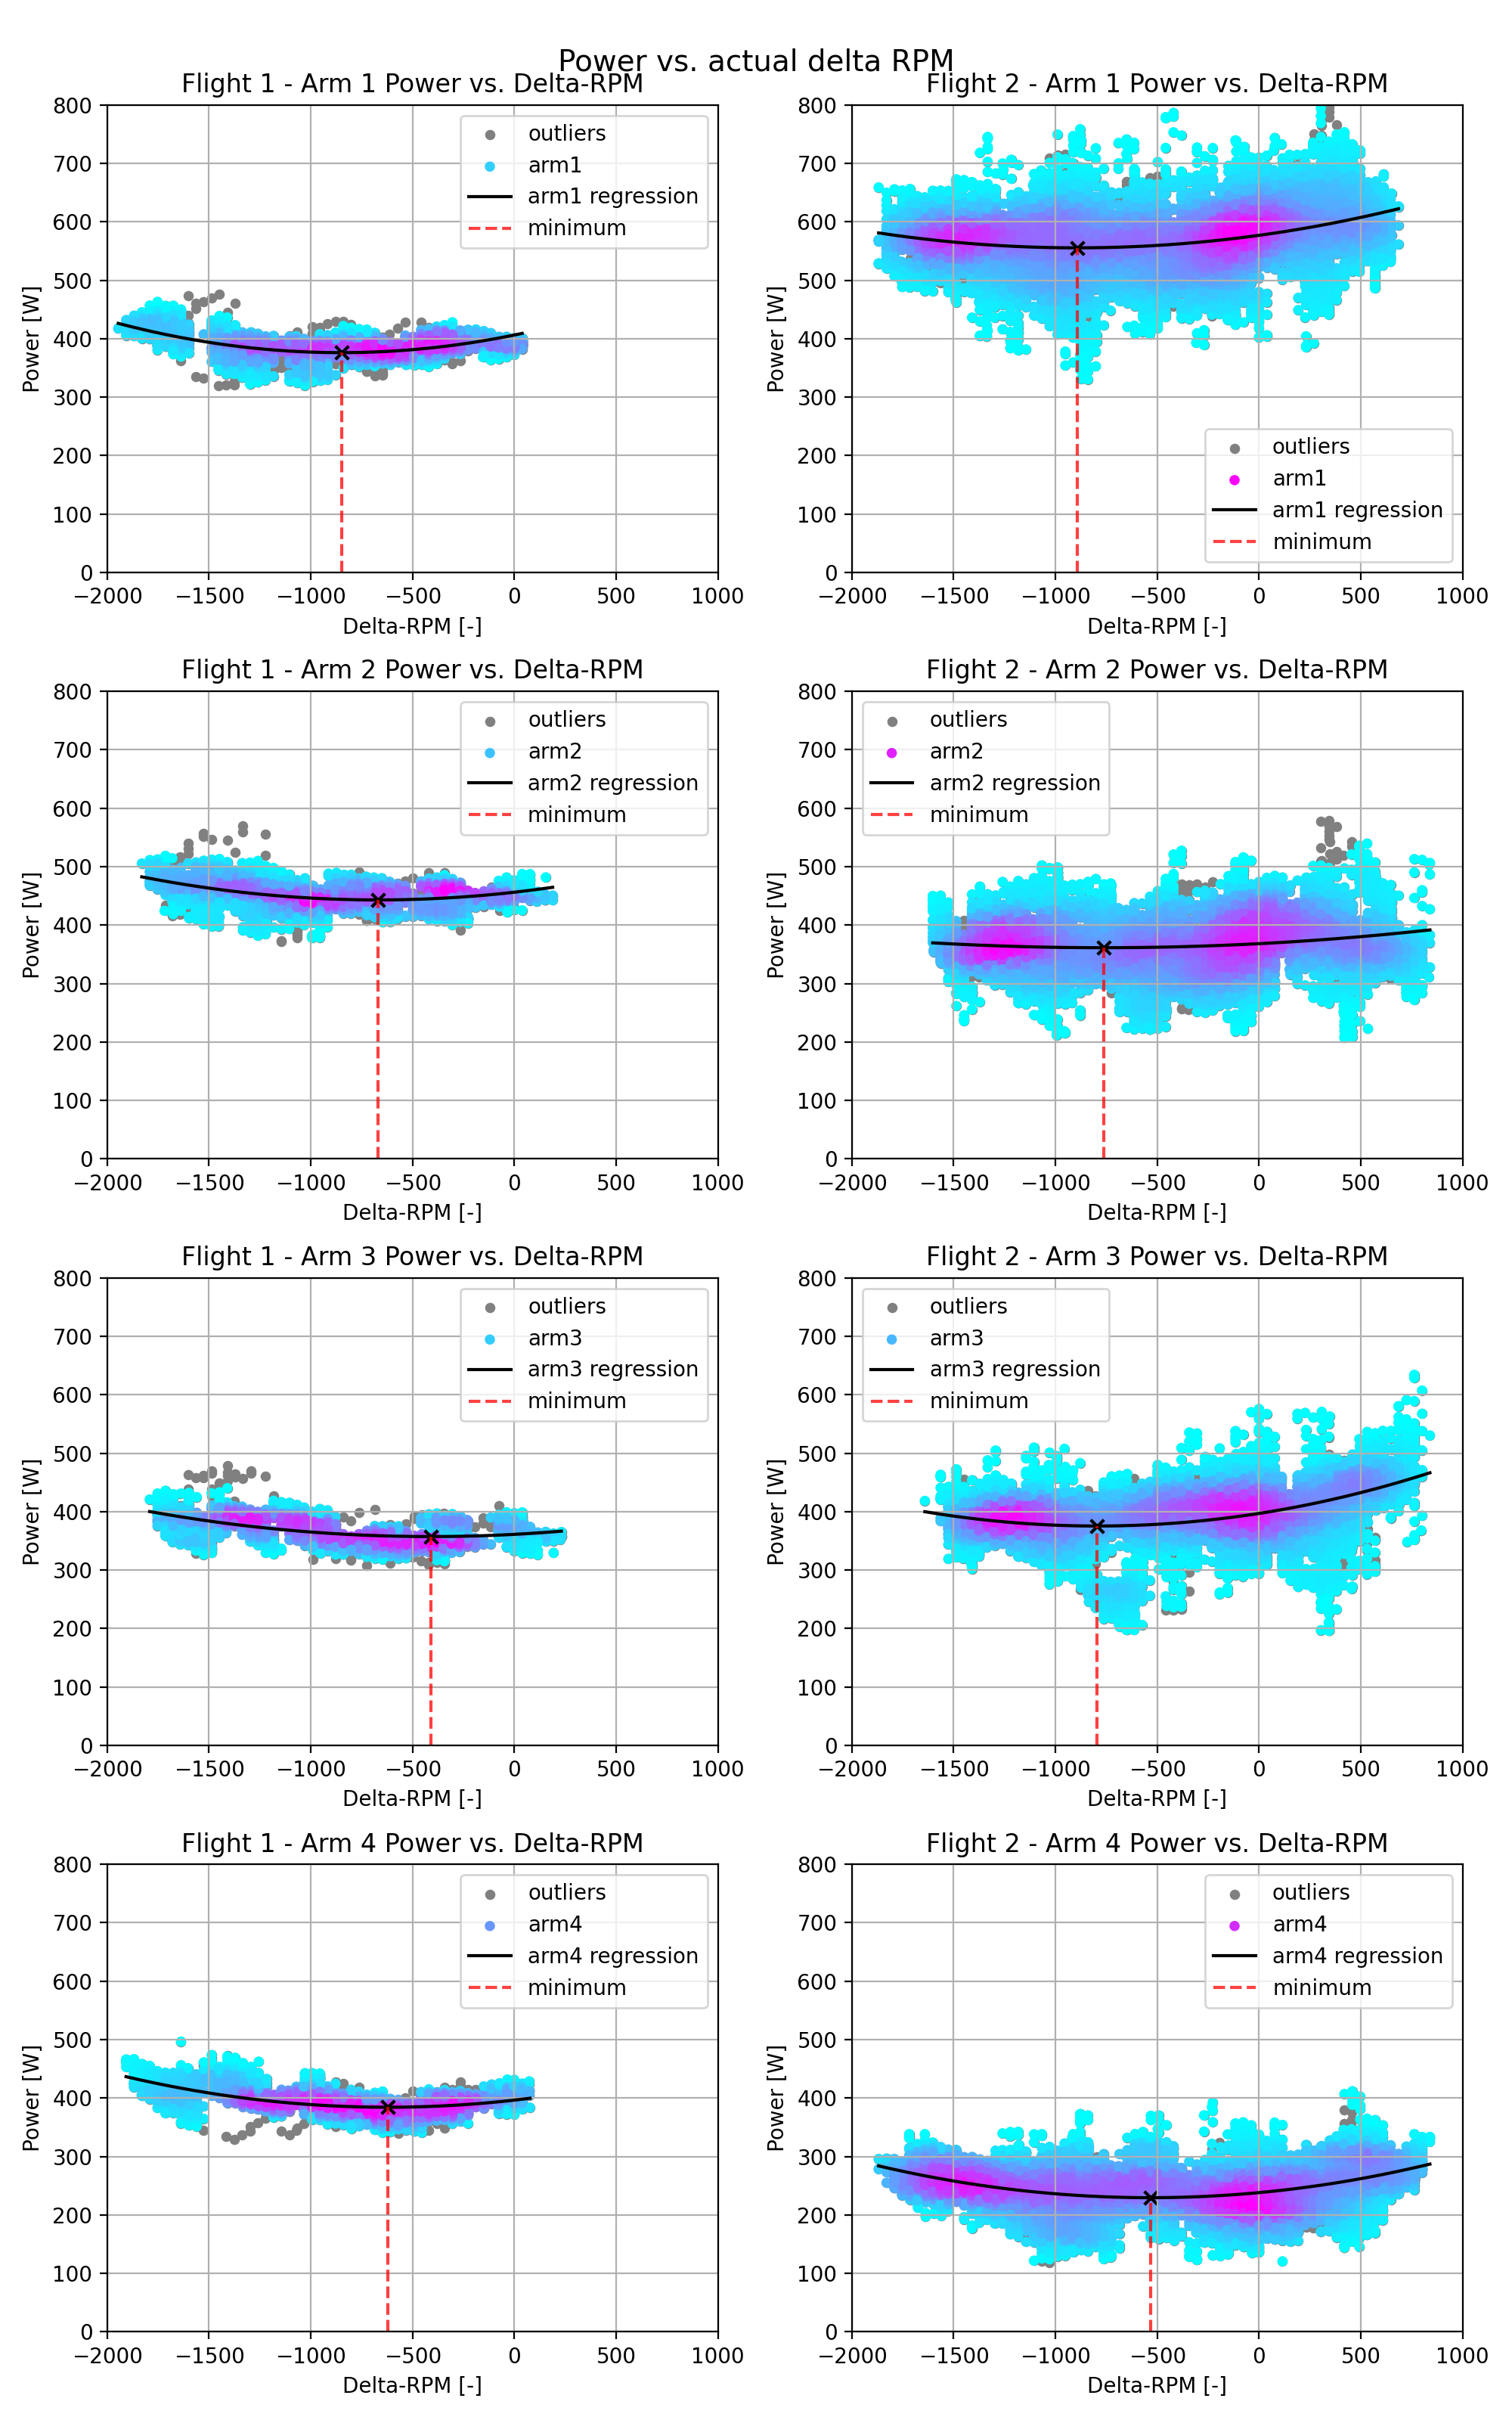

In [23]:
# Power per arm over deltaRPM

fig2, ax2 = plt.subplots(4, 2, figsize=(10,16))
fig2.suptitle('Power vs. actual delta RPM', fontsize=14)

for i in range(2):
    # Plot unfiltered data to show outliers
    ax2[0][i].scatter(fdUnfiltered[i]['dRpmArm1'], fdUnfiltered[i]['pArm1'], color='gray', s=markersize, label='outliers')
    ax2[1][i].scatter(fdUnfiltered[i]['dRpmArm2'], fdUnfiltered[i]['pArm2'], color='gray', s=markersize, label='outliers')
    ax2[2][i].scatter(fdUnfiltered[i]['dRpmArm3'], fdUnfiltered[i]['pArm3'], color='gray', s=markersize, label='outliers')
    ax2[3][i].scatter(fdUnfiltered[i]['dRpmArm4'], fdUnfiltered[i]['pArm4'], color='gray', s=markersize, label='outliers')

    ax2[0][i].scatter(fdHover[i]['dRpmArm1'], fdHover[i]['pArm1'], c=kernelDensity[i][0], cmap='cool', s=markersize, label='arm1')
    ax2[1][i].scatter(fdHover[i]['dRpmArm2'], fdHover[i]['pArm2'], c=kernelDensity[i][1], cmap='cool', s=markersize, label='arm2')
    ax2[2][i].scatter(fdHover[i]['dRpmArm3'], fdHover[i]['pArm3'], c=kernelDensity[i][2], cmap='cool', s=markersize, label='arm3')
    ax2[3][i].scatter(fdHover[i]['dRpmArm4'], fdHover[i]['pArm4'], c=kernelDensity[i][3], cmap='cool', s=markersize, label='arm4')

    # plot regression curves
    ax2[0][i].plot(dRpmRange[i][0], dRpmRegCurve[i][0], color='k', label='arm1 regression')
    ax2[1][i].plot(dRpmRange[i][1], dRpmRegCurve[i][1], color='k', label='arm2 regression')
    ax2[2][i].plot(dRpmRange[i][2], dRpmRegCurve[i][2], color='k', label='arm3 regression')
    ax2[3][i].plot(dRpmRange[i][3], dRpmRegCurve[i][3], color='k', label='arm4 regression')
    
    # plot minimal dRPM
    ax2[0][i].plot([dRpmMin[i][0], dRpmMin[i][0]],[0, dRpmRegCurve[i][0].min()], 'r--', alpha=0.75, label='minimum')
    ax2[1][i].plot([dRpmMin[i][1], dRpmMin[i][1]],[0, dRpmRegCurve[i][1].min()], 'r--', alpha=0.75, label='minimum')
    ax2[2][i].plot([dRpmMin[i][2], dRpmMin[i][2]],[0, dRpmRegCurve[i][2].min()], 'r--', alpha=0.75, label='minimum')
    ax2[3][i].plot([dRpmMin[i][3], dRpmMin[i][3]],[0, dRpmRegCurve[i][3].min()], 'r--', alpha=0.75, label='minimum')
    
    ax2[0][i].scatter(dRpmMin[i][0], dRpmRegCurve[i][0].min(), marker='x', color='k', s=40)
    ax2[1][i].scatter(dRpmMin[i][1], dRpmRegCurve[i][1].min(), marker='x', color='k', s=40)
    ax2[2][i].scatter(dRpmMin[i][2], dRpmRegCurve[i][2].min(), marker='x', color='k', s=40)
    ax2[3][i].scatter(dRpmMin[i][3], dRpmRegCurve[i][3].min(), marker='x', color='k', s=40)
    
    
for i in range(4):
    for j in range(2):
        ax2[i][j].set_xlabel('Delta-RPM [-]')
        ax2[i][j].set_ylabel('Power [W]')
        ax2[i][j].set_title(f'Flight {j+1} - Arm {i+1} Power vs. Delta-RPM')
        ax2[i][j].set_xlim(-2000, 1000)
        ax2[i][j].set_ylim(0, 800)
        ax2[i][j].grid()
        ax2[i][j].legend()

fig2.tight_layout()

## Compare total vehicle power

In [24]:
# regression for total vehicle power

dRpmVehicleRange = []
dRpmVehicleCurve = []
dRpmVehicleMin = []

kernelDensity = []
for i in range(2):
    regRange, regCurve = perform_polynomial_regression(fdHover[i], 'dRpmVehicle', f'pVehicle')
    
    dRpmVehicleRange.append(regRange)
    dRpmVehicleCurve.append(regCurve)
    dRpmVehicleMin.append(regRange[np.argmin(regCurve)])
    
    # kernel density estimation
    values = np.vstack([fdHover[i]["dRpmVehicle"], fdHover[i]["pVehicle"]])
    
    kernelDensity.append(stats.gaussian_kde(values)(values))


<IPython.core.display.Javascript object>


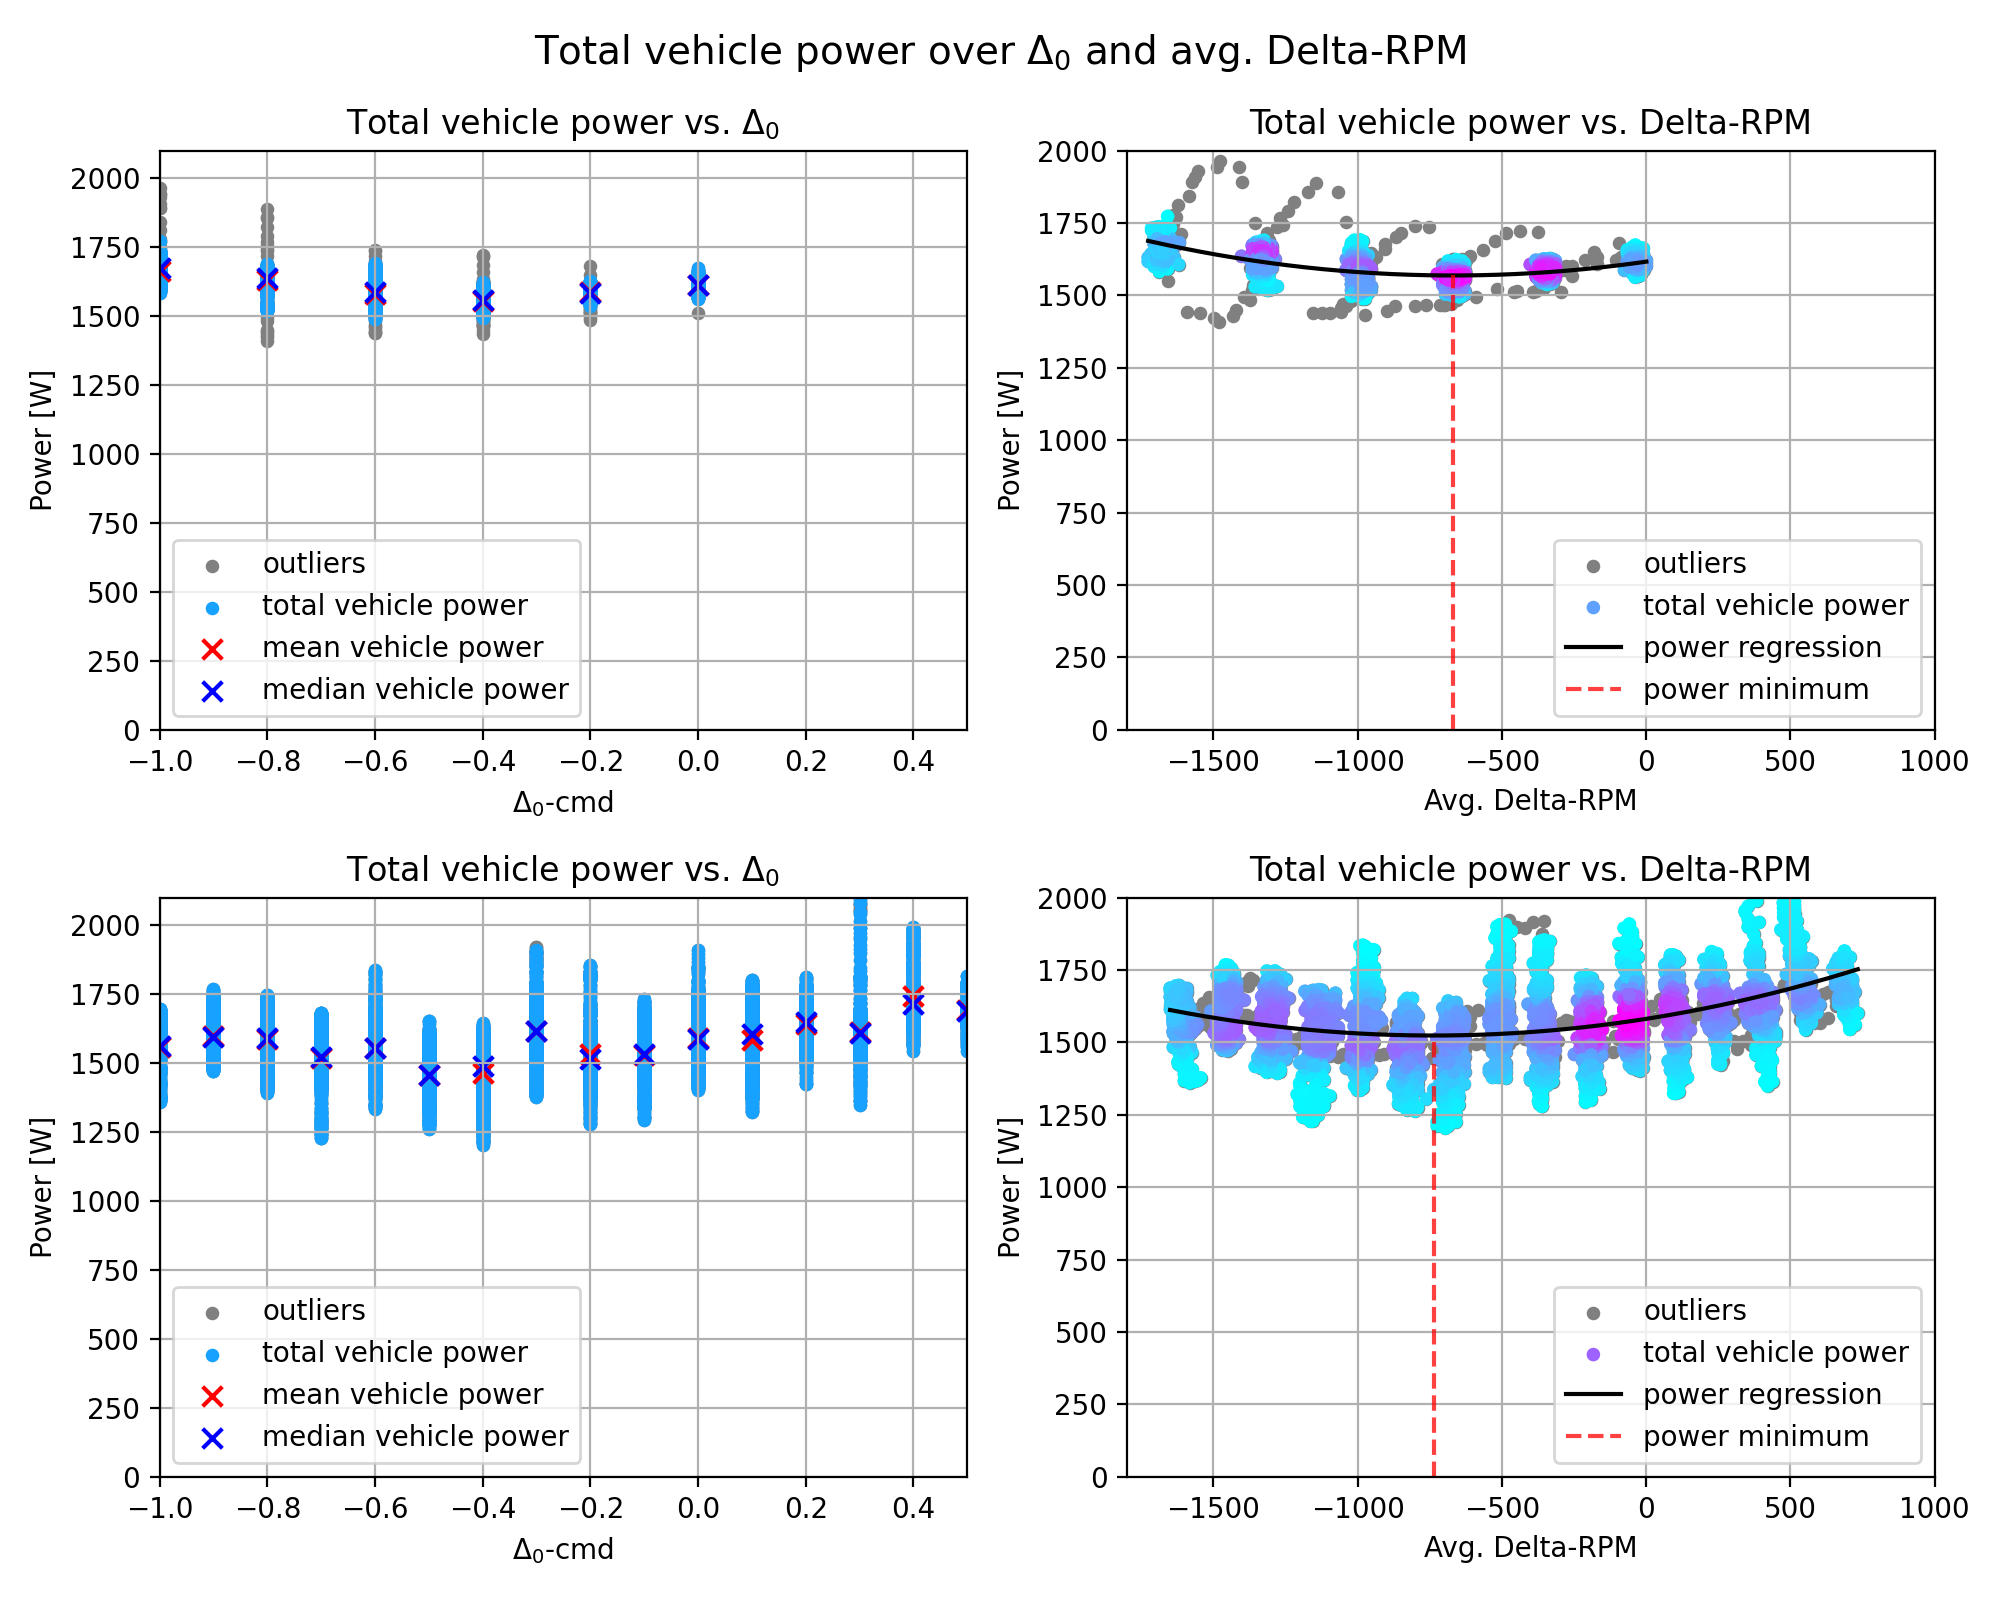

In [25]:
fig14, ax14 = plt.subplots(2,2,figsize=(10,8))
fig14.suptitle('Total vehicle power over $\Delta_0$ and avg. Delta-RPM', fontsize=14)

for i in range(2):
    
    # vehicle power over delta0
    ax14[i][0].scatter(fdUnfiltered[i]['delta0'], fdUnfiltered[i]['pVehicle'], color='gray', s=markersize, label='outliers')
    ax14[i][0].scatter(fdHover[i]['delta0'], fdHover[i]['pVehicle'], color=armCol, s=markersize, label='total vehicle power')

    ax14[i][0].scatter(delta0Mean[i].index, delta0Mean[i]['pVehicle'], marker='x', s=50, color=armMeanCol, label='mean vehicle power')
    ax14[i][0].scatter(delta0Median[i].index, delta0Median[i]['pVehicle'], marker='x', s=50, color='b', label='median vehicle power')

    # vehicle power over deltaRPM
    ax14[i][1].scatter(fdUnfiltered[i]['dRpmVehicle'], fdUnfiltered[i]['pVehicle'], color='gray', s=markersize, label='outliers')
    ax14[i][1].scatter(fdHover[i]['dRpmVehicle'], fdHover[i]['pVehicle'], c=kernelDensity[i], cmap='cool', s=markersize, label='total vehicle power')

    # plot regression curve
    ax14[i][1].plot(dRpmVehicleRange[i], dRpmVehicleCurve[i], color='k', label='power regression')
    ax14[i][1].plot([dRpmVehicleMin[i], dRpmVehicleMin[i]],[0, dRpmVehicleCurve[i].min()], 'r--', alpha=0.75, label='power minimum')

    ax14[i][0].set_xlabel('$\Delta_{0}$-cmd')
    ax14[i][0].set_ylabel('Power [W]')
    ax14[i][0].set_xlim(-1, 0.5)
    ax14[i][0].set_ylim(0, 2100)
    ax14[i][0].grid()
    ax14[i][0].legend(loc='lower left')
    ax14[i][0].set_title('Total vehicle power vs. $\Delta_0$')    

    ax14[i][1].set_title('Total vehicle power vs. Delta-RPM') 
    ax14[i][1].set_xlabel('Avg. Delta-RPM')
    ax14[i][1].set_ylabel('Power [W]')
    
    ax14[i][0].set_xlim(-1, 0.5)
    ax14[i][1].set_xlim(-1800, 1000)
    ax14[i][1].set_ylim(0, 2000)
    ax14[i][1].grid()
    ax14[i][1].legend()
   

fig14.tight_layout()